In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from keras.utils import image_dataset_from_directory, load_img, img_to_array
from keras.ops import expand_dims
from keras.applications.resnet50 import ResNet50, preprocess_input

2024-12-15 20:19:00.608028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734304740.715669    9525 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734304740.744643    9525 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 20:19:00.992014: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
image_size = (224, 224)
batch_size = 50

train_ds, val_ds = image_dataset_from_directory(
    "dataset_balanceado",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
)

classes = train_ds.class_names

Found 9600 files belonging to 12 classes.
Using 7680 files for training.
Using 1920 files for validation.


I0000 00:00:1734304747.157979    9525 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


2024-12-15 20:19:08.758846: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


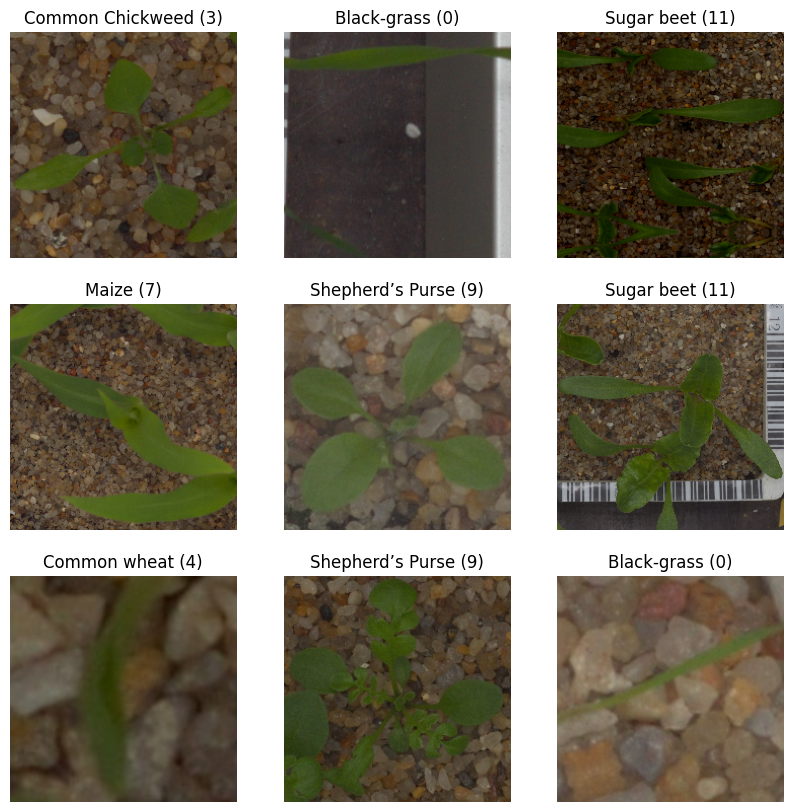

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        image = images[i].numpy().astype("uint8")
        label = np.argmax(labels[i])

        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(f"{classes[label]} ({label})")
        plt.axis("off")

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [5]:
base_model = ResNet50(
    include_top=True,
    weights=None,
    classes=len(classes),
)

In [6]:
inputs = tf.keras.Input(shape=image_size + (3,), name="input_image")

#x = data_augmentation(inputs)
x = preprocess_input(inputs)

outputs = base_model(x)

model = tf.keras.Model(inputs, outputs)

In [7]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_image[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_image[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_image[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 12)        │ 23,612,300 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,612,300 (90.07 MB)

 Trainable params: 23,559,180 (89.87 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [8]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [9]:
result = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
)

I0000 00:00:1734304808.087078    9653 service.cc:148] XLA service 0x7f3d6c003cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734304808.087546    9653 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-12-15 20:20:09.170214: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734304813.257433    9653 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-15 20:20:16.511988: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12716', 224 bytes spill stores, 224 bytes spill loads

I0000 00:00:1734304852.058726    9653 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-12-15 20:21:02.119272: 

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_9525/2100408816.py", line 1, in <module>

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 368, in fit

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 216, in function

  File "/home/augusto/anaconda3/envs/gpu_tf/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 129, in multi_step_on_iterator

Out of memory while trying to allocate 4135361920 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_44667]

In [ ]:
from matplotlib import pyplot as plt

plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
img = load_img("PetImages/Cat/10198.jpg", target_size=image_size)
plt.imshow(img)

img_array = img_to_array(img)
img_array = expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)